In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

#Número Top de Gens. En aquest cas vull els TOP100
n=100

#Fitxer que contè en TPM els gens codifcants excloent els MITOCONDRIALS més epxressats de manera ordenada decreixent.
teixits = pd.read_csv('D:/TFM/ANALISI_MODELS/Datasets/all_gensTPM_noversio_NOMITO_ZA.csv',sep =",")

In [2]:
#data = teixits.iloc[:, 1:4]
data=teixits

In [3]:
if (n==0 or n>(len(teixits.columns)-3)):
    n=len(teixits.columns)-3
    
data = teixits.iloc[:, 2:n+3]

In [4]:
data

,SMTSD,ENSG00000248527,ENSG00000087086,ENSG00000131095,ENSG00000197971,ENSG00000225630,ENSG00000123560,ENSG00000075624,ENSG00000111640,ENSG00000120885,...,ENSG00000185883,ENSG00000126432,ENSG00000102109,ENSG00000110955,ENSG00000145425,ENSG00000244734,ENSG00000172809,ENSG00000156298,ENSG00000018625,ENSG00000134590
0,Brain - Cortex,5852.0,2444.0,993.4,2566.00,1408.0,1436.00,1418.0,1433.0,960.5,...,541.9,348.5,232.5,506.0,323.0,69.26,355.2,364.8,379.2,457.2
1,Brain - Cerebellum,4863.0,1229.0,479.8,102.70,801.8,77.02,1275.0,1306.0,1045.0,...,676.7,584.0,237.1,747.3,476.3,142.70,308.9,347.8,389.1,427.2
2,Brain - Cortex,6309.0,1653.0,842.0,192.80,1281.0,269.60,1109.0,1301.0,1264.0,...,513.8,358.6,526.1,414.8,273.6,189.90,276.8,359.1,690.4,401.4
3,Brain - Cerebellum,5897.0,1082.0,521.1,360.60,969.4,207.40,936.8,890.8,885.3,...,512.9,436.1,206.1,507.1,472.4,960.20,308.3,253.6,261.5,316.1
4,Brain - Cortex,5461.0,1551.0,695.9,215.40,1118.0,432.20,1574.0,1814.0,924.4,...,847.1,519.6,1195.0,600.3,254.2,80.50,364.7,357.9,229.9,608.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2636,Brain - Cortex,6258.0,1646.0,907.6,385.10,943.8,372.80,1401.0,1805.0,1457.0,...,835.8,491.0,614.9,588.0,273.4,58.76,330.7,377.2,339.4,535.8
2637,Brain - Cerebellum,4839.0,1415.0,1328.0,184.80,946.5,166.50,1143.0,1249.0,1883.0,...,555.5,521.4,144.3,565.5,456.7,262.90,340.4,399.5,445.0,373.8
2638,Brain - Cortex,4931.0,2849.0,1268.0,73.87,1225.0,120.40,2797.0,1188.0,1244.0,...,437.8,306.1,417.2,364.1,464.5,1973.00,380.1,242.0,451.7,445.6
2639,Brain - Cerebellum,5456.0,894.4,805.0,28.05,1152.0,44.74,1001.0,769.1,1571.0,...,478.0,310.3,111.1,564.1,478.4,234.60,316.6,355.9,292.4,267.3


In [5]:
#Creació conjunt train i test

x,y=data.iloc[:, 1:n+1],data.iloc[:, 0]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=123)

x_train = np.log2(x_train+1)
x_test = np.log2(x_test+1)

In [6]:
#Definim PCA

pca = PCA()

z= pca.fit_transform(x_train)

x_train_pca = z
x_test_pca  = pca.transform(x_test)

15 components expliquen un 95% de la variança. De 100 dimensions a 15


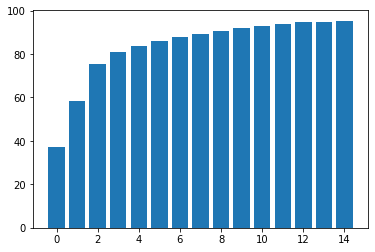

In [7]:
total = sum(pca.explained_variance_)

k = 0
current_variance = 0
while current_variance/total < 0.95:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print(k, " components expliquen un 95% de la variança. De ",n," dimensions a ", k, sep='')

pca = PCA(n_components=k)

x_train.pca = pca.fit(x_train)
x_train_pca = pca.transform(x_train)

x_test_pca = pca.transform(x_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

In [8]:
#Dinàmicament agafo el numero de Dimensions de PCA: k

principalDf = pd.DataFrame(data = x_train_pca[:,0:k])
             #, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalDf.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.732797,-4.082906,-1.369554,-1.259125,-0.084210,-1.811647,-1.077244,1.714457,-1.407689,-0.178183,-0.189388,-0.398595,-0.174646,0.373447,1.857993
1,-3.329314,4.222498,6.694227,2.410722,-0.456715,-0.631376,0.373852,0.320952,-0.288528,-0.598060,0.216004,-0.762162,0.066637,-0.936100,0.585391
2,8.866312,-3.583983,3.672170,-3.632115,3.567140,4.558941,2.454179,-0.201008,1.497249,-0.906016,-4.019989,0.673977,0.373292,-0.376667,-1.062484
3,15.232540,-3.963830,3.550125,1.106281,-0.249253,0.232992,0.879293,0.279035,-0.200909,4.300335,-0.177333,1.273493,-0.143689,-0.171684,-0.095313
4,4.117753,-4.742464,-0.324925,0.304870,0.618911,-1.082554,2.878471,0.738401,0.141289,-0.517823,-0.886079,0.213446,-0.721087,-0.247676,-0.600457


In [9]:
x_train_pca[:,0:11].shape

(2112, 11)

In [10]:
principalDf.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

finalDF = pd.concat([principalDf, y_train], axis=1)

finalDF.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,SMTSD
0,1.732797,-4.082906,-1.369554,-1.259125,-0.084210,-1.811647,-1.077244,1.714457,-1.407689,-0.178183,-0.189388,-0.398595,-0.174646,0.373447,1.857993,Brain - Hippocampus
1,-3.329314,4.222498,6.694227,2.410722,-0.456715,-0.631376,0.373852,0.320952,-0.288528,-0.598060,0.216004,-0.762162,0.066637,-0.936100,0.585391,Brain - Cerebellum
2,8.866312,-3.583983,3.672170,-3.632115,3.567140,4.558941,2.454179,-0.201008,1.497249,-0.906016,-4.019989,0.673977,0.373292,-0.376667,-1.062484,Brain - Frontal Cortex (BA9)
3,15.232540,-3.963830,3.550125,1.106281,-0.249253,0.232992,0.879293,0.279035,-0.200909,4.300335,-0.177333,1.273493,-0.143689,-0.171684,-0.095313,Brain - Nucleus accumbens (basal ganglia)
4,4.117753,-4.742464,-0.324925,0.304870,0.618911,-1.082554,2.878471,0.738401,0.141289,-0.517823,-0.886079,0.213446,-0.721087,-0.247676,-0.600457,Brain - Frontal Cortex (BA9)


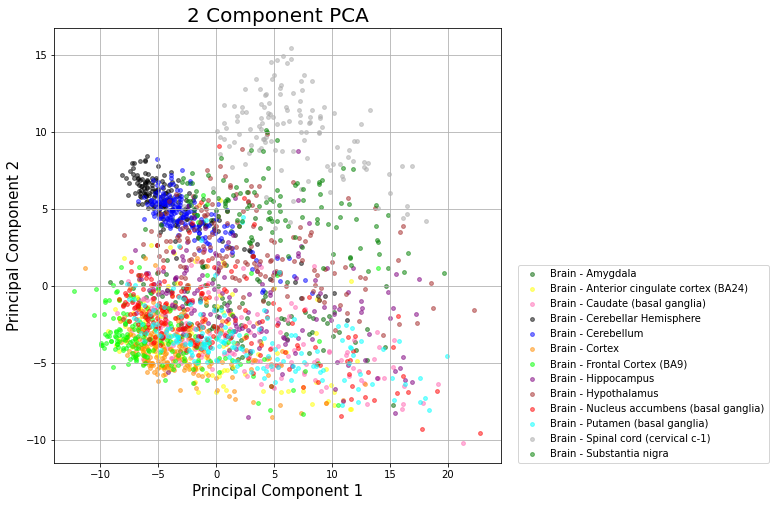

In [11]:
#Visualitzo la projecció 2D

fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = ['Brain - Amygdala',
           'Brain - Anterior cingulate cortex (BA24)',
           'Brain - Caudate (basal ganglia)',
           'Brain - Cerebellar Hemisphere',
           'Brain - Cerebellum',
           'Brain - Cortex',
           'Brain - Frontal Cortex (BA9)',
           'Brain - Hippocampus', 
           'Brain - Hypothalamus',       
           'Brain - Nucleus accumbens (basal ganglia)', 
           'Brain - Putamen (basal ganglia)',
           'Brain - Spinal cord (cervical c-1)',
           'Brain - Substantia nigra']

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 13))

colors = {'red':   ((0.0, 0.0, 0.0),
                    (0.5, 0.0, 0.1),
                    (1.0, 1.0, 1.0)),

          'green': ((0.0, 0.0, 0.0),
                    (1.0, 0.0, 0.0)),

          'blue':  ((0.0, 0.0, 1.0),
                    (0.5, 0.1, 0.0),
                    (1.0, 0.0, 0.0))
          }

colors = {"black","hotpink", "purple", "green","lime", "blue", "red","yellow","cyan", "darkgreen","darkorange", "brown", "darkgrey"}

for target, color in zip(targets,colors):
    indicesToKeep = finalDF['SMTSD'] == target    
    ax.scatter(finalDF.loc[indicesToKeep, 0]
               , finalDF.loc[indicesToKeep, 1]
               , c = color               
               , s = 15, alpha=0.5)
ax.legend(targets, loc=(1.04,0))


ax.grid()

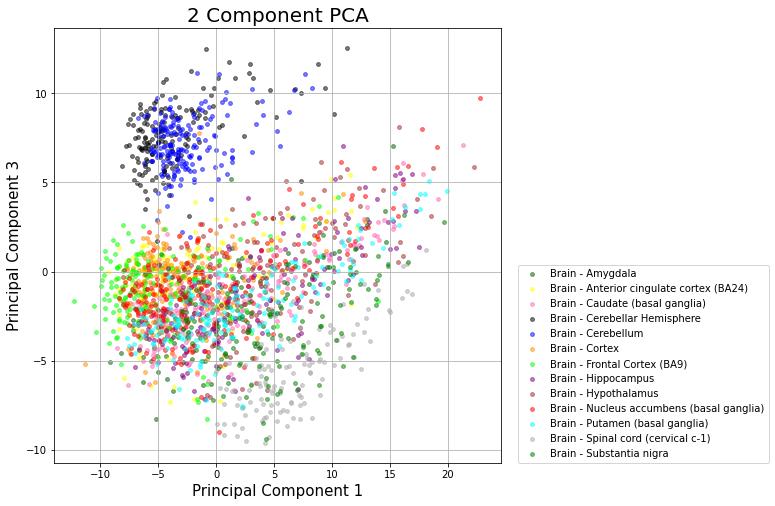

In [12]:

fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = ['Brain - Amygdala',
           'Brain - Anterior cingulate cortex (BA24)',
           'Brain - Caudate (basal ganglia)',
           'Brain - Cerebellar Hemisphere',
           'Brain - Cerebellum',
           'Brain - Cortex',
           'Brain - Frontal Cortex (BA9)',
           'Brain - Hippocampus', 
           'Brain - Hypothalamus',       
           'Brain - Nucleus accumbens (basal ganglia)', 
           'Brain - Putamen (basal ganglia)',
           'Brain - Spinal cord (cervical c-1)',
           'Brain - Substantia nigra']

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 13))

colors = {'red':   ((0.0, 0.0, 0.0),
                    (0.5, 0.0, 0.1),
                    (1.0, 1.0, 1.0)),

          'green': ((0.0, 0.0, 0.0),
                    (1.0, 0.0, 0.0)),

          'blue':  ((0.0, 0.0, 1.0),
                    (0.5, 0.1, 0.0),
                    (1.0, 0.0, 0.0))
          }

colors = {"black","hotpink", "purple", "green","lime", "blue", "red","yellow","cyan", "darkgreen","darkorange", "brown", "darkgrey"}

for target, color in zip(targets,colors):
    indicesToKeep = finalDF['SMTSD'] == target    
    ax.scatter(finalDF.loc[indicesToKeep, 0]
               , finalDF.loc[indicesToKeep, 2]
               , c = color               
               , s = 15, alpha=0.5)
ax.legend(targets, loc=(1.04,0))


ax.grid()

<b>tSNE Perplexity 30</b>

In [13]:
tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1, random_state=1234)

points = tsne.fit_transform(x_train)

tsne_df = pd.DataFrame({'X':points[:,0],
                        'Y':points[:,1],
                        'Tipus Teixit':y_train})
tsne_df.head()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2112 samples in 0.000s...
[t-SNE] Computed neighbors for 2112 samples in 0.220s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2112
[t-SNE] Computed conditional probabilities for sample 2000 / 2112
[t-SNE] Computed conditional probabilities for sample 2112 / 2112
[t-SNE] Mean sigma: 2.116703
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.482887
[t-SNE] KL divergence after 1000 iterations: 1.039824


,X,Y,Tipus Teixit
0,-21.741562,8.811769,Brain - Hippocampus
1,70.190636,-13.418384,Brain - Cerebellum
2,2.863645,31.861059,Brain - Frontal Cortex (BA9)
3,0.097694,39.679756,Brain - Nucleus accumbens (basal ganglia)
4,-23.233946,24.087461,Brain - Frontal Cortex (BA9)


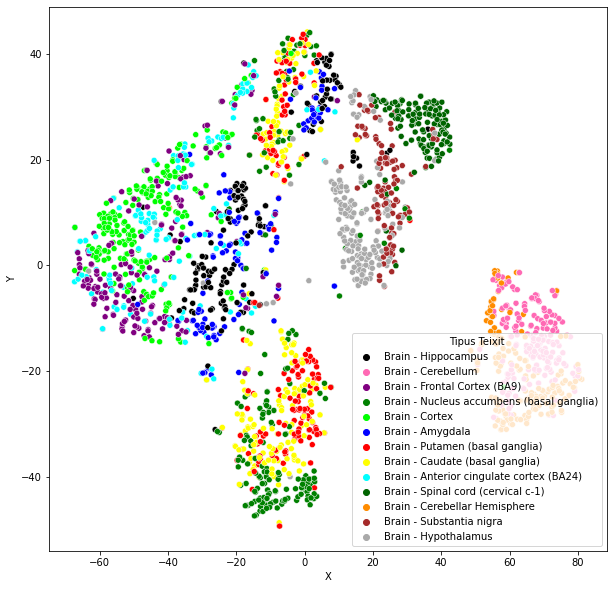

In [14]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x="X", y="Y",
              hue="Tipus Teixit",
              palette=["black","hotpink", "purple", "green","lime", "blue", "red","yellow","cyan", "darkgreen","darkorange", "brown", "darkgrey"],
              #legend='full',              
              data=tsne_df);

<b>Realització de Models</b>

<b>Model Classificador kNN</b>

In [15]:
#Emprant Reducció PCA
#============================

# Grid d'hiperparàmetres
# ==============================================================================
param_grid={"n_neighbors":range(5,25), "weights": ["uniform","distance"]}


# Validació creuada
# ==============================================================================
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()


grid = GridSearchCV(model , param_grid = param_grid,
                           cv=10, scoring = 'accuracy', n_jobs=-1,                            
                           verbose = 1,                           
                           return_train_score = True)

#Tots els PCA recomanats per 95%
_ = grid.fit(X = x_train_pca, y = y_train)


# Càlculs

means = _.cv_results_["mean_test_score"]
stds = _.cv_results_["std_test_score"]
params = _.cv_results_["params"]
ranks = _.cv_results_["rank_test_score"]

for ordre, mitjana, std, parametres in zip(ranks, means, stds, params):
    print(ordre,"# Prec. mitjana: ",mitjana*100," desv.: ", std*100, " paràmetres: ",parametres)


# Resultats del grid
# ==============================================================================
resultats = pd.DataFrame(grid.cv_results_)
resultats.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)


# Millors hiperparàmetres amb validació creuada
# ==============================================================================
print("----------------------------------------")
print("(kNN) Millors hiperparàmetres trobats (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

model2 = grid.best_estimator_

r_model2 = grid.best_score_

# Prediccions test
# ==============================================================================

prediccions2 = model2.predict(x_test_pca)

# Accuracy de test del model
# ==============================================================================
accuracy2 = accuracy_score(
            y_true    = y_test,
            y_pred    = prediccions2,
            normalize = True
           )
print("")
print(f"(kNN) El accuracy de test és: {100*accuracy2}%")


# Matriu de confusió de les prediccions de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test.ravel(),
    prediccions2,
    rownames=['Real'],
    colnames=['Predicció']
)
confusion_matrix

Fitting 10 folds for each of 40 candidates, totalling 400 fits
40 # Prec. mitjana:  68.08615756058303  desv.:  1.8878405460391787  paràmetres:  {'n_neighbors': 5, 'weights': 'uniform'}
39 # Prec. mitjana:  68.37096485737281  desv.:  1.5867330701682627  paràmetres:  {'n_neighbors': 5, 'weights': 'distance'}
38 # Prec. mitjana:  68.46575158723061  desv.:  2.002700591090504  paràmetres:  {'n_neighbors': 6, 'weights': 'uniform'}
36 # Prec. mitjana:  69.27143879102209  desv.:  2.0270416316004733  paràmetres:  {'n_neighbors': 6, 'weights': 'distance'}
33 # Prec. mitjana:  69.55423410533845  desv.:  2.1289412816570525  paràmetres:  {'n_neighbors': 7, 'weights': 'uniform'}
37 # Prec. mitjana:  69.27076813019761  desv.:  2.1030532377329445  paràmetres:  {'n_neighbors': 7, 'weights': 'distance'}
34 # Prec. mitjana:  69.36689618170438  desv.:  2.498647947674831  paràmetres:  {'n_neighbors': 8, 'weights': 'uniform'}
35 # Prec. mitjana:  69.3192792631673  desv.:  2.077786284652771  paràmetres:  {'n

Predicció,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),Brain - Cerebellar Hemisphere,Brain - Cerebellum,Brain - Cortex,Brain - Frontal Cortex (BA9),Brain - Hippocampus,Brain - Hypothalamus,Brain - Nucleus accumbens (basal ganglia),Brain - Putamen (basal ganglia),Brain - Spinal cord (cervical c-1),Brain - Substantia nigra
Real,,,,,,,,,,,,,
Brain - Amygdala,19,1,1,0,0,0,0,13,0,0,0,0,0
Brain - Anterior cingulate cortex (BA24),4,9,0,0,0,6,8,1,0,0,0,0,0
Brain - Caudate (basal ganglia),0,0,41,0,0,0,1,0,0,5,5,0,0
Brain - Cerebellar Hemisphere,0,0,0,41,10,0,0,0,0,0,0,0,0
Brain - Cerebellum,0,0,0,8,47,0,0,0,0,0,0,0,0
Brain - Cortex,2,4,0,0,0,32,2,2,0,0,0,0,0
Brain - Frontal Cortex (BA9),2,6,1,0,0,5,18,0,0,1,0,0,0
Brain - Hippocampus,8,1,0,0,0,0,1,26,1,0,0,2,2
Brain - Hypothalamus,0,0,0,1,0,0,0,1,28,1,0,0,8


<b>SVM</b>

In [16]:
#Emprant Reducció PCA
#============================
# Grid d'hiperparàmetres
# ==============================================================================
param_grid = {"C": (0.01, 0.1, 1, 10, 100, 150, 200, 250 , 300, 1000), "gamma": (0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.005, 0.1,0.5, 1, 10)}

# Validació creuada
# ==============================================================================
from sklearn import svm

model = svm.SVC()
grid = GridSearchCV(model, param_grid = param_grid,                           
                           cv=10, scoring = 'accuracy', n_jobs=-1,                            
                           verbose = 1,
                           return_train_score = True)

#Tots els PCA recomanats per 95%
_ = grid.fit(X = x_train_pca, y = y_train)


# Càlculs

means = _.cv_results_["mean_test_score"]
stds = _.cv_results_["std_test_score"]
params = _.cv_results_["params"]
ranks = _.cv_results_["rank_test_score"]

for ordre, mitjana, std, parametres in zip(ranks, means, stds, params):
    print(ordre,"# Prec. mitjana: ",mitjana*100," desv.: ", std*100, " paràmetres: ",parametres)

    
# Resultats del grid
# ==============================================================================
resultats = pd.DataFrame(grid.cv_results_)
resultats.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

# Millors hiperparàmetres amb validació creuada
# ==============================================================================
print("----------------------------------------")
print("(SVM) Millors hiperparàmetres trobats (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

model3 = grid.best_estimator_

r_model3 = grid.best_score_


# Prediccions test
# ==============================================================================

prediccions3 = model3.predict(x_test_pca)

# Accuracy de test del model
# ==============================================================================
accuracy3 = accuracy_score(
            y_true    = y_test,
            y_pred    = prediccions3,
            normalize = True
           )
print("")
print(f"(SVM) El accuracy de test és: {100*accuracy3}%")


# Matriu de confusió de les prediccions de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test.ravel(),
    prediccions3,
    rownames=['Real'],
    colnames=['Predicció']
)
confusion_matrix

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
76 # Prec. mitjana:  10.038004113386389  desv.:  0.19511709742031305  paràmetres:  {'C': 0.01, 'gamma': 1e-06}
76 # Prec. mitjana:  10.038004113386389  desv.:  0.19511709742031305  paràmetres:  {'C': 0.01, 'gamma': 1e-05}
76 # Prec. mitjana:  10.038004113386389  desv.:  0.19511709742031305  paràmetres:  {'C': 0.01, 'gamma': 0.0001}
76 # Prec. mitjana:  10.038004113386389  desv.:  0.19511709742031305  paràmetres:  {'C': 0.01, 'gamma': 0.001}
66 # Prec. mitjana:  18.607931682017348  desv.:  0.3671619442506001  paràmetres:  {'C': 0.01, 'gamma': 0.01}
67 # Prec. mitjana:  18.56076187069659  desv.:  0.41809688853056276  paràmetres:  {'C': 0.01, 'gamma': 0.005}
76 # Prec. mitjana:  10.038004113386389  desv.:  0.19511709742031305  paràmetres:  {'C': 0.01, 'gamma': 0.1}
76 # Prec. mitjana:  10.038004113386389  desv.:  0.19511709742031305  paràmetres:  {'C': 0.01, 'gamma': 0.5}
76 # Prec. mitjana:  10.038004113386389  desv.:  0.19

Predicció,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),Brain - Cerebellar Hemisphere,Brain - Cerebellum,Brain - Cortex,Brain - Frontal Cortex (BA9),Brain - Hippocampus,Brain - Hypothalamus,Brain - Nucleus accumbens (basal ganglia),Brain - Putamen (basal ganglia),Brain - Spinal cord (cervical c-1),Brain - Substantia nigra
Real,,,,,,,,,,,,,
Brain - Amygdala,27,0,0,0,0,0,0,7,0,0,0,0,0
Brain - Anterior cingulate cortex (BA24),5,14,0,0,0,1,8,0,0,0,0,0,0
Brain - Caudate (basal ganglia),0,0,43,0,0,1,0,0,0,3,5,0,0
Brain - Cerebellar Hemisphere,0,0,0,47,4,0,0,0,0,0,0,0,0
Brain - Cerebellum,0,0,0,1,54,0,0,0,0,0,0,0,0
Brain - Cortex,0,2,0,0,0,37,2,1,0,0,0,0,0
Brain - Frontal Cortex (BA9),1,6,0,0,0,0,26,0,0,0,0,0,0
Brain - Hippocampus,5,3,1,0,0,0,1,30,1,0,0,0,0
Brain - Hypothalamus,0,0,0,1,0,0,0,1,31,1,0,0,5


<b>Arbres de decisió</b>

In [17]:
#Emprant Reducció PCA
#============================

# Grid d'hiperparàmetres
# ==============================================================================
param_grid={'min_samples_split' :(2, 10, 20, 50 ,75,100,500,1000),'max_depth':(4,5,6,7,8,9,10,20,50,100,200,300,400,450,460,470,500,550,600,650,700,1000)}

# Validació creuada
# ==============================================================================
import sklearn.tree

model=sklearn.tree.DecisionTreeClassifier()

grid = GridSearchCV(model, param_grid = param_grid, 
                           cv=10, scoring = 'accuracy', n_jobs=-1,                            
                           verbose = 1,
                           return_train_score = True)

#Tots els PCA recomanats per 95%
_ = grid.fit(X = x_train_pca, y = y_train)


# Càlculs

means = _.cv_results_["mean_test_score"]
stds = _.cv_results_["std_test_score"]
params = _.cv_results_["params"]
ranks = _.cv_results_["rank_test_score"]

for ordre, mitjana, std, parametres in zip(ranks, means, stds, params):
    print(ordre,"# Prec. mitjana: ",mitjana*100," desv.: ", std*100, " paràmetres: ",parametres)


# Resultats del grid
# ==============================================================================
resultats = pd.DataFrame(grid.cv_results_)
resultats.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)


# Millors hiperparàmetres amb validació creuada
# ==============================================================================
print("----------------------------------------")
print("(Arbre de Decissió) Millors hiperparàmetres trobats (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

model4 = grid.best_estimator_

r_model4 = grid.best_score_

# Prediccions test
# ==============================================================================

prediccions4 = model4.predict(x_test_pca)

# Accuracy de test del model
# ==============================================================================
accuracy4 = accuracy_score(
            y_true    = y_test,
            y_pred    = prediccions4,
            normalize = True
           )
print("")
print(f"(Arbre de Decissió) El accuracy de test és: {100*accuracy4}%")


# Matriu de confusió de les prediccions de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test.ravel(),
    prediccions4,
    rownames=['Real'],
    colnames=['Predicció']
)
confusion_matrix

Fitting 10 folds for each of 176 candidates, totalling 1760 fits
127 # Prec. mitjana:  42.42443888044353  desv.:  3.3993726681940744  paràmetres:  {'max_depth': 4, 'min_samples_split': 2}
129 # Prec. mitjana:  42.377045515514624  desv.:  3.4057466573750985  paràmetres:  {'max_depth': 4, 'min_samples_split': 10}
127 # Prec. mitjana:  42.42443888044353  desv.:  3.412562054942927  paràmetres:  {'max_depth': 4, 'min_samples_split': 20}
130 # Prec. mitjana:  42.235536081552354  desv.:  3.5573371082164047  paràmetres:  {'max_depth': 4, 'min_samples_split': 50}
132 # Prec. mitjana:  41.80877224358401  desv.:  3.2617644260779977  paràmetres:  {'max_depth': 4, 'min_samples_split': 75}
131 # Prec. mitjana:  41.85616560851292  desv.:  3.263371903320717  paràmetres:  {'max_depth': 4, 'min_samples_split': 100}
154 # Prec. mitjana:  34.94321738352858  desv.:  1.5946619018483654  paràmetres:  {'max_depth': 4, 'min_samples_split': 500}
155 # Prec. mitjana:  29.87659840829831  desv.:  1.080113410552079

Predicció,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),Brain - Cerebellar Hemisphere,Brain - Cerebellum,Brain - Cortex,Brain - Frontal Cortex (BA9),Brain - Hippocampus,Brain - Hypothalamus,Brain - Nucleus accumbens (basal ganglia),Brain - Putamen (basal ganglia),Brain - Spinal cord (cervical c-1),Brain - Substantia nigra
Real,,,,,,,,,,,,,
Brain - Amygdala,19,5,1,0,0,0,0,7,0,1,0,0,1
Brain - Anterior cingulate cortex (BA24),6,9,0,0,0,3,10,0,0,0,0,0,0
Brain - Caudate (basal ganglia),0,1,37,0,1,0,1,1,0,9,2,0,0
Brain - Cerebellar Hemisphere,0,0,0,42,7,0,0,1,1,0,0,0,0
Brain - Cerebellum,0,1,0,4,46,2,0,0,0,1,0,0,1
Brain - Cortex,1,2,1,0,2,26,6,1,0,2,0,1,0
Brain - Frontal Cortex (BA9),2,8,0,0,0,4,16,1,0,1,1,0,0
Brain - Hippocampus,11,0,3,0,0,0,2,16,6,0,1,1,1
Brain - Hypothalamus,0,0,0,0,2,0,0,1,26,3,0,1,6


<b>Random Forest</b>

In [18]:
#Emprant Reducció PCA
#============================

# Grid d'hiperparàmetres
# ==============================================================================
param_grid={'n_estimators' :(10, 50 ,100 ,200, 250, 400),'max_depth':(6,7,8,9,10,11,12,15,20,25,30)}

# Validació creuada
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

grid = GridSearchCV(model, param_grid = param_grid, 
                           cv=10, scoring = 'accuracy', n_jobs=-1,                            
                           verbose = 1,
                           return_train_score = True)

#Tots els PCA recomanats per 95%
_ = grid.fit(X = x_train_pca, y = y_train)


# Càlculs

means = _.cv_results_["mean_test_score"]
stds = _.cv_results_["std_test_score"]
params = _.cv_results_["params"]
ranks = _.cv_results_["rank_test_score"]

for ordre, mitjana, std, parametres in zip(ranks, means, stds, params):
    print(ordre,"# Prec. mitjana: ",mitjana*100," desv.: ", std*100, " paràmetres: ",parametres)


# Resultats del grid
# ==============================================================================
resultats = pd.DataFrame(grid.cv_results_)
resultats.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)


# Millors hiperparàmetres amb validació creuada
# ==============================================================================
print("----------------------------------------")
print("(Random Forest) Millors hiperparàmetres trobats (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

model5 = grid.best_estimator_

r_model5 = grid.best_score_


# Prediccions test
# ==============================================================================

prediccions5 = model5.predict(x_test_pca)

# Accuracy de test del model
# ==============================================================================
accuracy5 = accuracy_score(
            y_true    = y_test,
            y_pred    = prediccions5,
            normalize = True
           )
print("")
print(f"(Random Forest) El accuracy de test és: {100*accuracy5}%")


# Matriu de confusió de les prediccions de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test.ravel(),
    prediccions5,
    rownames=['Real'],
    colnames=['Predicció']
)
confusion_matrix

Fitting 10 folds for each of 66 candidates, totalling 660 fits
66 # Prec. mitjana:  64.53702047751051  desv.:  3.0741549208981525  paràmetres:  {'max_depth': 6, 'n_estimators': 10}
55 # Prec. mitjana:  70.64249306983814  desv.:  3.047377600222764  paràmetres:  {'max_depth': 6, 'n_estimators': 50}
54 # Prec. mitjana:  71.58968970759189  desv.:  2.7423738073980117  paràmetres:  {'max_depth': 6, 'n_estimators': 100}
51 # Prec. mitjana:  72.01734775999284  desv.:  3.463070495285636  paràmetres:  {'max_depth': 6, 'n_estimators': 200}
53 # Prec. mitjana:  71.82866851470983  desv.:  3.099444518710806  paràmetres:  {'max_depth': 6, 'n_estimators': 250}
50 # Prec. mitjana:  72.1114638290262  desv.:  3.205482864858532  paràmetres:  {'max_depth': 6, 'n_estimators': 400}
61 # Prec. mitjana:  67.9933828131986  desv.:  2.528901180431563  paràmetres:  {'max_depth': 7, 'n_estimators': 10}
47 # Prec. mitjana:  72.68085486899759  desv.:  4.274935072600014  paràmetres:  {'max_depth': 7, 'n_estimators': 5

Predicció,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),Brain - Cerebellar Hemisphere,Brain - Cerebellum,Brain - Cortex,Brain - Frontal Cortex (BA9),Brain - Hippocampus,Brain - Hypothalamus,Brain - Nucleus accumbens (basal ganglia),Brain - Putamen (basal ganglia),Brain - Spinal cord (cervical c-1),Brain - Substantia nigra
Real,,,,,,,,,,,,,
Brain - Amygdala,21,1,0,0,0,1,1,8,1,1,0,0,0
Brain - Anterior cingulate cortex (BA24),4,14,0,0,0,2,7,1,0,0,0,0,0
Brain - Caudate (basal ganglia),0,0,40,0,0,1,1,0,0,8,2,0,0
Brain - Cerebellar Hemisphere,0,0,0,45,6,0,0,0,0,0,0,0,0
Brain - Cerebellum,0,0,0,3,52,0,0,0,0,0,0,0,0
Brain - Cortex,0,2,1,0,0,37,2,0,0,0,0,0,0
Brain - Frontal Cortex (BA9),2,5,1,0,0,3,22,0,0,0,0,0,0
Brain - Hippocampus,8,0,0,0,0,0,2,26,0,0,0,2,3
Brain - Hypothalamus,0,0,0,1,0,0,0,0,30,2,0,1,5


In [19]:
print("##################################################")
print(f"Model kNN Accuracy: {100*r_model2:.2f}%")
print(f"Model kNN, Accuracy de test és: {100*accuracy2:.2f}%")
print("##################################################")
print(f"Model Svm Accuracy: {100*r_model3:.2f}%")
print(f"Model Svm, Accuracy de test és: {100*accuracy3:.2f}%")
print("##################################################")
print(f"Model Arbre de Decisió: {100*r_model4:.2f}%")
print(f"Model Arbre de Decisió, Accuracy de test és: {100*accuracy4:.2f}%")
print("##################################################")
print(f"Model Random Forest: {100*r_model5:.2f}%")
print(f"Model Random Forest, Accuracy de test és: {100*accuracy5:.2f}%")


##################################################
Model kNN Accuracy: 71.26%
Model kNN, Accuracy de test és: 71.46%
##################################################
Model Svm Accuracy: 84.00%
Model Svm, Accuracy de test és: 83.36%
##################################################
Model Arbre de Decisió: 58.48%
Model Arbre de Decisió, Accuracy de test és: 58.79%
##################################################
Model Random Forest: 75.90%
Model Random Forest, Accuracy de test és: 77.32%
